## Описание проекта

На основе данных за 2016 год о продажах компьютерных игр, оценок пользователей и экспертов, жанров и платформ, необходимо определить закономерности, определяющие успешность игры, чтобы спланировать, на какой продукт делать ставку в 2017 году.   
   
**План проекта:**
- Ознакомиться с имеющимися данными.
- Подготовить данные для анализа.
- Провести исследовательский анализ данных.
- Составить портрет пользователя каждого региона.
- Проверить гипотезы.
- Сделать общий вывод и дать рекомендации для бизнеса.

## Описание данных

Данные за 2016 год:  
   
Name — название игры   
Platform — платформа  
Year_of_Release — год выпуска  
Genre — жанр игры  
NA_sales — продажи в Северной Америке (миллионы проданных копий)  
EU_sales — продажи в Европе (миллионы проданных копий)  
JP_sales — продажи в Японии (миллионы проданных копий)  
Other_sales — продажи в других странах (миллионы проданных копий)  
Critic_Score — оценка критиков (максимум 100)  
User_Score — оценка пользователей (максимум 10)  
Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.
   
Данные могут быть неполными.

In [1]:
#Импортируем необходимые библиотеки.
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
#Импортируем данные.
data = pd.read_csv('/datasets/games.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
data.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


## Предобработка данных

Приведем все названия столбцов к единому регистру.

In [5]:
data = data.rename(columns={'Name':'name', 'Platform':'platform', 'Year_of_Release':'year_of_release', 'Genre':'genre', 'NA_sales':'na_sales', 'EU_sales':'eu_sales', 'JP_sales':'jp_sales', 'Other_sales':'other_sales', 'Critic_Score':'critic_score', 'User_Score':'user_score', 'Rating':'rating'})

Строки с пропусками в столбцах name, genre и year_of_release составляют совсем малую часть от всех данных, соответсвенно, строки с пропусками в данных столбцах можно удалить. Строк с пропусками в столбцах critic_score, user_score и rating слишком много, их нельзя удалить. Пропуски в данных столбцах могут быть связаны с тем, что игры не оценивались, соответсвенно, заменить данные пропуски нельзя ни нулями, ни средними или медианными значениями по столбцу. Лучше оставить пропуски. Заменим tbd в столбце user_score на nan.

In [6]:
#data.isna().sum()
data.dropna(subset = ['year_of_release'], inplace=True)
data.dropna(subset = ['name'], inplace=True)
data.dropna(subset = ['genre'], inplace=True)
data.loc[(data['user_score'] == 'tbd'), 'user_score'] = 'nan'

Заменим пропуски в стобце rating на "no_rating".

In [7]:
data['rating'] = data['rating'].fillna("no_rating")

Заменим тип данных float на int в столбце year_released, и тип данных object в столбце user_score на float.

In [8]:
data['year_of_release'] = data['year_of_release'].astype(int)
data['user_score'] = data['user_score'].astype(float)

Добавим столбец с суммой продаж во всех регионах.

In [9]:
data['all_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

## Исследовательский анализ данных

Посчитаем, сколько игр было выпущено за каждый год. До 1994 года выпускалось совсем мало игр. Соответственно, данные до 1994 года можно отбросить.

In [10]:
data.pivot_table(index='year_of_release', aggfunc='count')['name']

year_of_release
1980       9
1981      46
1982      36
1983      17
1984      14
1985      14
1986      21
1987      16
1988      15
1989      17
1990      16
1991      41
1992      43
1993      60
1994     121
1995     219
1996     263
1997     289
1998     379
1999     338
2000     350
2001     482
2002     829
2003     775
2004     762
2005     939
2006    1006
2007    1197
2008    1427
2009    1426
2010    1255
2011    1136
2012     653
2013     544
2014     581
2015     606
2016     502
Name: name, dtype: int64

In [11]:
data = data.query('year_of_release >= 1994').copy()

Посмотрим суммарные продажи по платформам.

In [12]:
data.pivot_table(index='platform', values='all_sales', aggfunc='sum')['all_sales'].sort_values()

platform
PCFX       0.03
3DO        0.10
NES        0.11
TG16       0.16
SCD        0.36
NG         1.23
WS         1.42
GEN        8.13
DC        15.95
SAT       33.59
PSV       53.81
WiiU      82.19
SNES      84.67
GB       152.08
XOne     159.32
GC       196.73
N64      218.01
XB       251.57
PC       252.66
3DS      257.81
PSP      289.53
GBA      312.88
PS4      314.14
PS       727.58
DS       802.76
Wii      891.18
PS3      931.34
X360     961.24
PS2     1233.56
Name: all_sales, dtype: float64

Самые прибыльные платформы: PS, DS, Wii, PS3, X360, PS2.

In [13]:
best_platforms = data.query('platform == "PS" or platform == "DS" or platform == "Wii" or platform == "PS3" or platform == "X360" or platform == "PS2"')

<AxesSubplot:xlabel='year_of_release'>

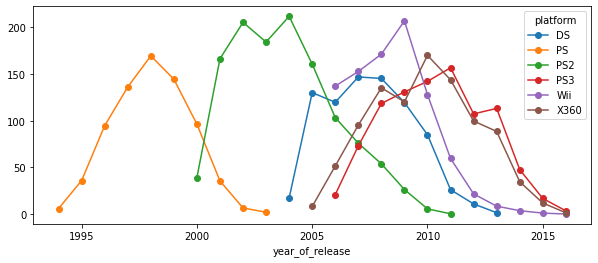

In [14]:
best_platforms.pivot_table(index='year_of_release', columns='platform', values='all_sales', aggfunc='sum').plot(kind='line', figsize=(10,4),  style = 'o-')

По данному графику видно, что в среднем платформа пользуется популярностью около 10 лет, затем она исчезает и ей на смену приходит новая. Таким образом, для построения прогноза на 2017 год, стоит исследовать последние 5 лет, чтобы не учитывать платформы, популярность которых уже почти угасла, и уделить больше внимания новым набирающим популярность платформам. Возьмем данные за 2011 - 2016 гг.

In [15]:
data_2011_2016 = data.query('2010 < year_of_release < 2017').copy()

<AxesSubplot:xlabel='platform'>

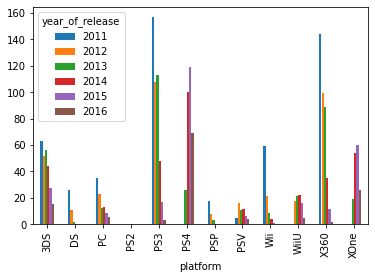

In [16]:
data_2011_2016.pivot_table(index='platform', columns='year_of_release', values='all_sales', aggfunc='sum').plot(kind='bar')

Несмотря на то, что по данному графику по продажам лидируют платформы PS3 и X360, их популярность очень сило упала за последние пару лет, можно предположить, что их популярность в 2017 году будет еще меньше. Стоит делать упор на платформах, популярность которых растет, а именно PS4 и XOne.

<AxesSubplot:xlabel='all_sales', ylabel='platform'>

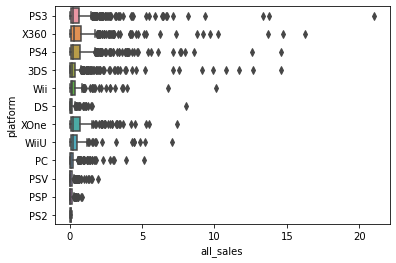

In [17]:
sns.boxplot(data = data_2011_2016, x = 'all_sales', y = 'platform')

(0.0, 1.5)

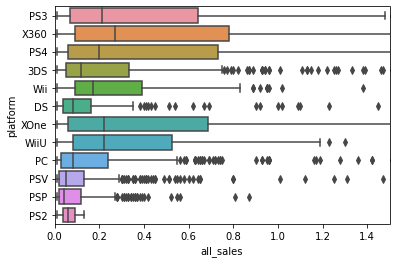

In [18]:
sns.boxplot(data = data_2011_2016, x = 'all_sales', y = 'platform')
plt.xlim(0, 1.5)

На данных графиках также видны платформы - лидеры продаж: PS3, PS4, X360, XOne.

Посмотрим, как влияют отзывы на продажи внутри самой потенциально прибыльной платформы - PS4.

In [19]:
data_2011_2016.query('platform == "PS4"').corr()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,all_sales
year_of_release,1.000000,-0.248961,-0.208306,-0.060993,-0.234796,-0.021142,0.152447,-0.235032
na_sales,-0.248961,1.000000,0.785362,0.472981,0.944259,0.415008,-0.020933,0.928160
eu_sales,-0.208306,0.785362,1.000000,0.464563,0.944698,0.346720,-0.048925,0.958157
jp_sales,-0.060993,0.472981,0.464563,1.000000,0.496467,0.322358,0.171332,0.527129
other_sales,-0.234796,0.944259,0.944698,0.496467,1.000000,0.409191,-0.035639,0.998051
critic_score,-0.021142,0.415008,0.346720,0.322358,0.409191,1.000000,0.557654,0.406568
user_score,0.152447,-0.020933,-0.048925,0.171332,-0.035639,0.557654,1.000000,-0.031957
all_sales,-0.235032,0.928160,0.958157,0.527129,0.998051,0.406568,-0.031957,1.000000


<AxesSubplot:xlabel='all_sales', ylabel='critic_score'>

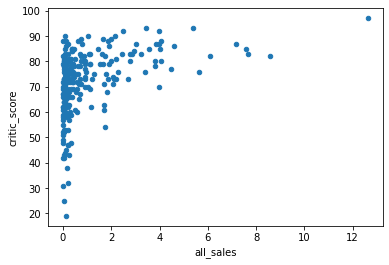

In [20]:
data_2011_2016.query('platform == "PS4"').plot(x='all_sales', y='critic_score', kind='scatter')

<AxesSubplot:xlabel='all_sales', ylabel='user_score'>

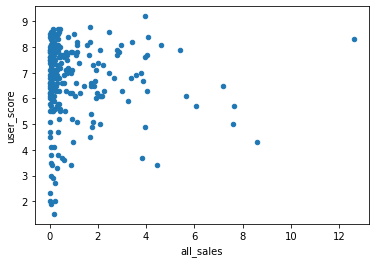

In [21]:
data_2011_2016.query('platform == "PS4"').plot(x='all_sales', y='user_score', kind='scatter')

Коэффициент корреляции Пирсона и диаграммы рассеяния показывают некоторую взаимосвязь между отзывами критиков и пользователей и продажами. Чем выше отзыв критиков, тем выше продажи. При этом отзывы пользователей практически никак не влияют на продажи. Проверим эти выводы на продажах среди других платформ.

In [22]:
data_2011_2016.query('platform != "PS4"').corr()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,all_sales
year_of_release,1.000000,-0.068546,-0.055892,0.003222,-0.074233,0.106620,-0.037043,-0.062162
na_sales,-0.068546,1.000000,0.806934,0.276286,0.799419,0.297275,0.018312,0.934087
eu_sales,-0.055892,0.806934,1.000000,0.309024,0.942916,0.308023,0.011489,0.934284
jp_sales,0.003222,0.276286,0.309024,1.000000,0.234275,0.125062,0.168990,0.474154
other_sales,-0.074233,0.799419,0.942916,0.234275,1.000000,0.284723,0.020969,0.901629
critic_score,0.106620,0.297275,0.308023,0.125062,0.284723,1.000000,0.531354,0.316886
user_score,-0.037043,0.018312,0.011489,0.168990,0.020969,0.531354,1.000000,0.039663
all_sales,-0.062162,0.934087,0.934284,0.474154,0.901629,0.316886,0.039663,1.000000


<AxesSubplot:xlabel='all_sales', ylabel='critic_score'>

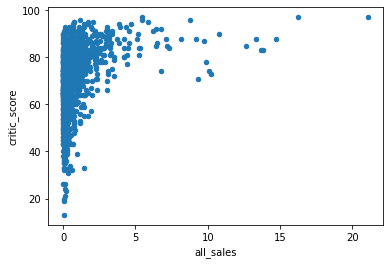

In [23]:
data_2011_2016.query('platform != "PS4"').plot(x='all_sales', y='critic_score', kind='scatter')

<AxesSubplot:xlabel='all_sales', ylabel='user_score'>

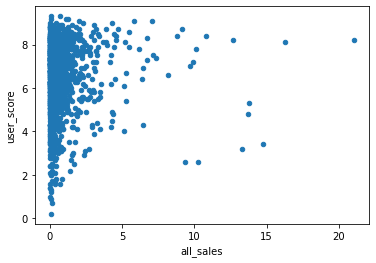

In [24]:
data_2011_2016.query('platform != "PS4"').plot(x='all_sales', y='user_score', kind='scatter')

Анализ по всем платформам подтверждает выводы, сделанные на примере платформы PS4. Чем выше отзыв критиков - тем выше продаже, влияние отзыва пользователя на продажи минимально.

Посмотрим на влияние жанров игр на продажи.

<AxesSubplot:xlabel='genre'>

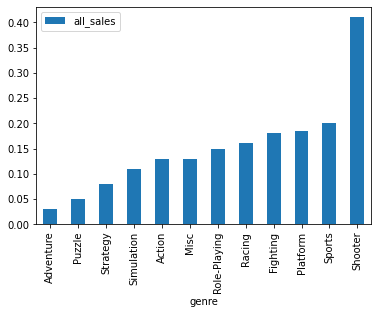

In [25]:
data_2011_2016.pivot_table(index='genre', values='all_sales', aggfunc='median').sort_values(by='all_sales').plot(kind='bar')

Наблюдается сильная зависимость объема продаж от жанра игры. Самый популярный жанр - shooter, прибыли с продаж игр в этом жанре сильно выше, чем от остальных жанров. Остальные жанры пользуются гораздо меньшей популярностью и, соотвественно, менее прибыльны. Также можно выделить жанры Sports, Platform и Fighting.

## Портрет пользователя

In [26]:
data_2011_2016.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
29,Call of Duty: Modern Warfare 3,X360,2011,Shooter,9.04,4.24,0.13,1.32,88.0,3.4,M,14.73
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,no_rating,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,no_rating,14.60


**Составим портрет пользователя из Северной Америки.**

<AxesSubplot:xlabel='platform'>

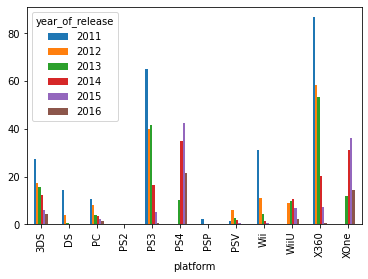

In [27]:
data_2011_2016.pivot_table(index='platform', columns='year_of_release', values='na_sales', aggfunc='sum').plot(kind='bar')

Самыми популярными платформами в Северной Америке с 2011 по 2016 год были X360 и PS3. Однако, под конец исследуемого периода они стали сильно терять популярность, в то время как популярность PS4 и XOne стала сильно расти.   
Топ-5 самых популярных платформ за 2010-2015 гг.:  X360, PS3, PS4, XOne, Wii.

<AxesSubplot:xlabel='genre'>

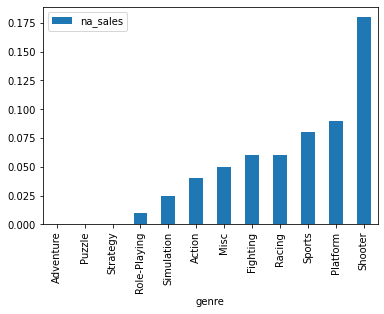

In [28]:
data_2011_2016.pivot_table(index='genre', values='na_sales', aggfunc='median').sort_values(by='na_sales').plot(kind='bar')

Топ-5 самых популярных жанров игр в Европе: Shooter, Platform, Sports, Racing и Fighting. При этом количество продаж игр в жанре Shooter сильно больше остальных.

<AxesSubplot:xlabel='rating'>

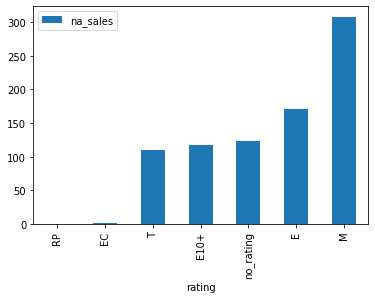

In [29]:
data_2011_2016.pivot_table(index='rating', values='na_sales', aggfunc='sum').sort_values(by='na_sales').plot(kind='bar')

Данный график показывает, что рейтинг ESRB влияет на количество продаж. Самыми популярными являются игры для взрослых, далее по прибыльности идут игры категории "для всех". Средние продажи у игр без рейтинга, категории 10+ и для подростков. Минимальные продажи у игр для детей младшего возраста.

**Составим портрет пользователя из Европы.**

<AxesSubplot:xlabel='platform'>

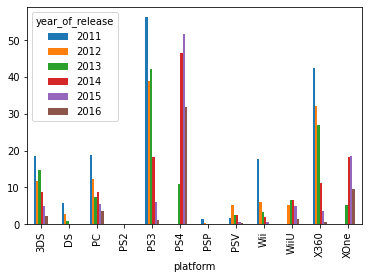

In [30]:
data_2011_2016.pivot_table(index='platform', columns='year_of_release', values='eu_sales', aggfunc='sum').plot(kind='bar')

Топ-5 самых популярных платформ за 2011-2016 гг.:  PS3, PS4, X360, XOne и PC. При этом продажи игр платформ PS3, X360 и PC сильно упали за последние несколько лет выборки, в то время как продажb игр платформ PS4 и XOne сильно возросли.

<AxesSubplot:xlabel='genre'>

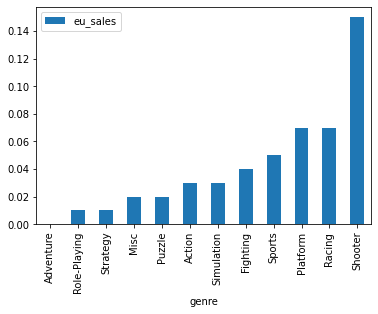

In [31]:
data_2011_2016.pivot_table(index='genre', values='eu_sales', aggfunc='median').sort_values(by='eu_sales').plot(kind='bar')

Топ-5 самых популярных жанров игр в Европе: Shooter, Racing, Platform, Sports и Fighting. При этом количество продаж игр в жанре Shooter сильно больше остальных.

<AxesSubplot:xlabel='rating'>

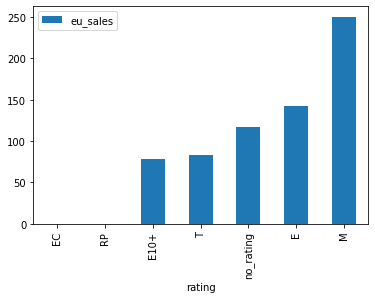

In [32]:
data_2011_2016.pivot_table(index='rating', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales').plot(kind='bar')

В Европе рейтинг ESRB также влияет на количество продаж. Самыми популярными являются игры для взрослых, далее по прибыльности идут игры категории "для всех". Средние продажи у игр без рейтинга, категории 10+ и для подростков. Совсем нет продаж у игр для детей младшего возраста.

**Составим портрет пользователя из Японии.**

<AxesSubplot:xlabel='platform'>

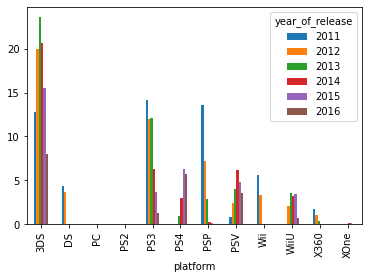

In [33]:
data_2011_2016.pivot_table(index='platform', columns='year_of_release', values='jp_sales', aggfunc='sum').plot(kind='bar')

Топ-5 самых популярных платформ в Японии за 2011-2016 годы: 3DS, PS3, PSP, PS4 и PSV. В то же время популярность платформ 3DS, PSP, и PS3 сильно сильно упала за последние несколько лет, наблюдается неплохой рост продаж игр PS4 и PSV. Их можно считать потенциально прибыльными платформами.

<AxesSubplot:xlabel='genre'>

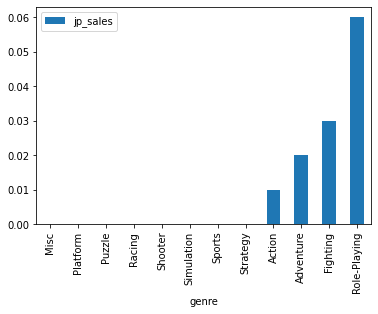

In [34]:
data_2011_2016.pivot_table(index='genre', values='jp_sales', aggfunc='median').sort_values(by='jp_sales').plot(kind='bar')

Продажи игр в Японии не отличаются таким разнообразием жанров, как в Европе и Северной Америке. Самым популярным является жанр Role-Playing, его продажи сильно выше продаж всех остальных жанров. Средние продажи у жанров Adventure и Fighting, низкие у жанра Action. Остальные жанры совсем не пользуются спросом.

<AxesSubplot:xlabel='rating'>

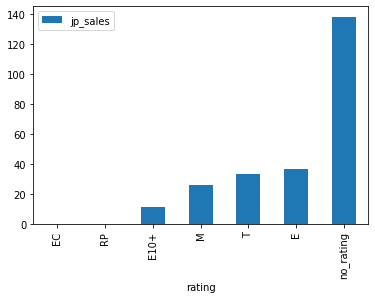

In [35]:
data_2011_2016.pivot_table(index='rating', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales').plot(kind='bar')

В Японии рейтинг ESRB также влияет на количество продаж. Самыми прибыльными являтся игры без рейтинга. Дальше по популярности идут игры для подростков и для всех. Не очень большие продажи у игр для взрослых, и совсем низкие продажи у игр для детей младшего возраста.

## Проверка гипотез

**Гипотеза 1**  
Небходимо проверить гипотезу, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые.  
H0 - средние рейтинги равны;  
Н1 - средние рейтинги отличаются.

In [36]:
alpha = 0.05
data_XOne = data_2011_2016.query('platform == "XOne"').copy()
data_PC = data_2011_2016.query('platform == "PC"').copy()
data_XOne.dropna(subset = ['user_score'], inplace=True)
data_PC.dropna(subset = ['user_score'], inplace=True)
results = st.ttest_ind(data_XOne['user_score'], data_PC['user_score'], equal_var=False) #Сравниваем выборки.
print('p-значение: ', results.pvalue)
if results.pvalue > alpha:
    print('Не получилось отвергнуть нулевую гипотезу.')
else:
    print('Отвергаем нулевую гипотезу.')

p-значение:  0.6130712247638477
Не получилось отвергнуть нулевую гипотезу.


Полученное значение p-value говорит о том, что вероятность получить различные значения случайно - 61%. Это значение слишком велико. Таким образом, на основе данной выборки нельзя отвергнуть гипотезу о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые. Среднее пользовательских рейтингов платформ Xbox One и PC в данной выборке отличается совсем не значительно:

In [37]:
print(data_XOne['user_score'].mean())
print(data_PC['user_score'].mean())

6.521428571428572
6.451791530944625


**Гипотеза 2**  
Необходимо проверить гипотезу, что средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.  
Н0 - рейтинги одинаковые;  
Н1 - рейтинги отличаются.

In [38]:
alpha = 0.05
data_action = data_2011_2016.query('genre == "Action"').copy()
data_sports = data_2011_2016.query('genre == "Sports"').copy()
data_action.dropna(subset = ['user_score'], inplace=True)
data_sports.dropna(subset = ['user_score'], inplace=True)
results = st.ttest_ind(data_action['user_score'], data_sports['user_score'], equal_var=False) #Сравниваем выборки.
print('p-значение: ', results.pvalue)
if results.pvalue > alpha:
    print('Не получилось отвергнуть нулевую гипотезу.')
else:
    print('Отвергаем нулевую гипотезу.')

p-значение:  8.285648549432565e-19
Отвергаем нулевую гипотезу.


Полученное значение p-value говорит о том, что вероятность получить различные значения случайно слишком мала, чтобы на основании данной выборки делать вывод о том, что рейтинги равны. Таким образом, данная выборка не позволяет отвергнуть гипотезу о том, что средние пользовательский рейтинги жанров Action и Sports различаюся.  В данной выборке средний пользовательский рейтинг по играм в жанре action в 1.14 раз больше, чем по играм в жанре sports:

In [39]:
print(data_action['user_score'].mean())
print(data_sports['user_score'].mean())
print(data_action['user_score'].mean() / data_sports['user_score'].mean())

6.775903614457831
5.650813008130081
1.1991024308730498


## Общий вывод

В рамках исследования был проведен анализ данных о продажах компьютерных игр.  
- Были обработаны данные. Удалены пропуски, не влияющие на результаты исследования.
- Были подсчитаны общие суммы продаж по играм во всех регионах.
- Был определен актуальный период для исследования: 2011 - 2016 гг.
- Был определены самые прибыльные платформы за весь период предоставленных данных: PS, DS, Wii, PS3, X360, PS2. Также были определены самые потенциально прибыльные платформы, на которые стоит делать ставку при планировании продаж на 2017 год: PS4 и XOne.
- Была проверена зависимость продаж игр от отзывов критиков и пользователей. Исследование показало, что отзывы критиков имеют сильное влияние на продажи. Чем выше отзыв - тем больше прибыль от продажи игры. При этом отзывы пользователей практически никак не влияют на продажи. Таким образом, при планировании продаж на 2017 год стоит учитывать именно отзывы критиков, а не пользователей.
- Были определены самые прибыльные жанры, на которые стоит делать упор при планировании продаж на 2017 год: Shooter, Sports, Platform и Fighting. При это жанр Shooter сильно популярнее остальных.
- Были составлены портреты пользователей из следующих регионов: Северная Америка, Европа, Япония. Было определено, что запросы средних пользователей из Северной Америки и Европы различаются незначительно, в то время как в Японии популярностью пользутся совсем другие платформы и жанры.
- Балы проверена гипотеза о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые. Предосталвенная выборка не позволила отвергнуть данную гипотезу.
- Была проверена гипотеза о том, что средние пользовательские рейтинги жанров Action и Sports разные. Предоставленная выборка не позволила отвергнуть данную гипотезу.  
  
Таким образом, можно выделить следующие рекомендации для магазина игр при планировании продаж на 2017 год:
- Упор следует делать на таких платформах, как PS4 и XOne.
- Следует акцентировать внимание на следующих жанрах игр: Shooter, Sports, Platform и Fighting.
- Рекомендуется обращать внимание на те игры, у которых выше рейтинг от критиков.